# About the Project
In this assignment, Kaggle competition called [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview) is used to try RNN learned in the week4 lecture.

***
## Problem Description
In this competition, 10000 hand labeled tweet data are used. Some of them are related to natural disaster and others are not.  
We are asked to develop machine learning algorithm to differentiate whether those tweets are actually based on natural disasters ore not.

This prediction algorithm may be used to monitor occurence of natural disaster in automated way.

In the dataset, Ground truth "positive" label indicates that the tweet is actually deribed from natual disaster events.  
Unlike image classification, this competition is related to natual language processing.

## Import Libraries

In [1]:
import re
import string
# for computation
import numpy as np
import pandas as pd
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for machien learning
import tensorflow as tf
import keras

from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Layer, Input, Bidirectional, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.stem import WordNetLemmatizer

from wordcloud import STOPWORDS

### Import NLTK(Natural Language Toolkit) Data
As we need preprocessing against raw data, let's use dedicated library for this to avoid re-inventing the wheels!

In [2]:
# import work_tokernizer
nltk.download('punkt')
# import pos_tag
nltk.download('averaged_perceptron_tagger')
# import wordnet (lexical database of semantic relations)
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imach\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\imach\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imach\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

***
## EDA
In this section, Explanatory Data Analysis is conducted.

Let's firstly load dataset and then see basic information using `df.info()` function.  
As we can see, keyword and location contain invalid data.

In [3]:
train_df = pd.read_csv("nlp-getting-started/train.csv")
test_df = pd.read_csv("nlp-getting-started/test.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### Raw data
And let's see how data looks like.  
Somehow, null data are concentrated in the very beggining of the dataset. So I'd like to show example data from the middle.

* **id**: identifier  
* **keyword**: Keyword from the tweet  
* **location**: Location where the tweet was sent  
* **text**: raw text of the tweet  
* **target**: Target variable. 1 if the tweet is related to natural disaster and 0 is not.  

In [6]:
train_df.iloc[26:36]

,id,keyword,location,text,target
26,38,NaN,NaN,Was in NYC last week!,0
27,39,NaN,NaN,Love my girlfriend,0
28,40,NaN,NaN,Cooool :),0
29,41,NaN,NaN,Do you like pasta?,0
30,44,NaN,NaN,The end!,0
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [7]:
print("Percentage of the missing values for each column in the training set.")
print(train_df.isna().sum()/train_df.shape[0] * 100)
print("")
print("Percentage of the missing values for each column in the test set.")
print(test_df.isna().sum()/test_df.shape[0] * 100)

Percentage of the missing values for each column in the training set.
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Percentage of the missing values for each column in the test set.
id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64


### Fill missing values in the keyword and location
To fill missing vlaues, let's assign some word against them.

In [8]:
for df in [train_df, test_df]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'invalid_{col}')
train_df.head()

,id,keyword,location,text,target
0,1,invalid_keyword,invalid_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,invalid_keyword,invalid_location,Forest fire near La Ronge Sask. Canada,1
2,5,invalid_keyword,invalid_location,All residents asked to 'shelter in place' are ...,1
3,6,invalid_keyword,invalid_location,"13,000 people receive #wildfires evacuation or...",1
4,7,invalid_keyword,invalid_location,Just got sent this photo from Ruby #Alaska as ...,1


### Number of unique value in the keyword and location
Let's see the number of unique values in keyword and location. There might be some insight by using those information.

Location seems quite different for each data. This seems a bit too dificult to use for training variable.   
This time, I couldn't have enought time. But ideally, we can convert location into more meaningful information by unifying glanularity (e.g. convert city name into region name).

In [9]:
print(f'Number of unique keyword in: \nTraining data - {train_df["keyword"].nunique()} \nTesting data - {test_df["keyword"].nunique()}')
print(f'\nNumber of unique location in : \nTraining data - {train_df["location"].nunique()} \nTesting data - {test_df["location"].nunique()}')

Number of unique keyword in: 
Training data - 222 
Testing data - 222

Number of unique location in : 
Training data - 3342 
Testing data - 1603


### Number of tweets per kerword

Number of tweets per keyword, and count value histogram are visualized below.  
As you can see, keyword count are well balanced. This is good indication as we can utilize these information effectively without processing!

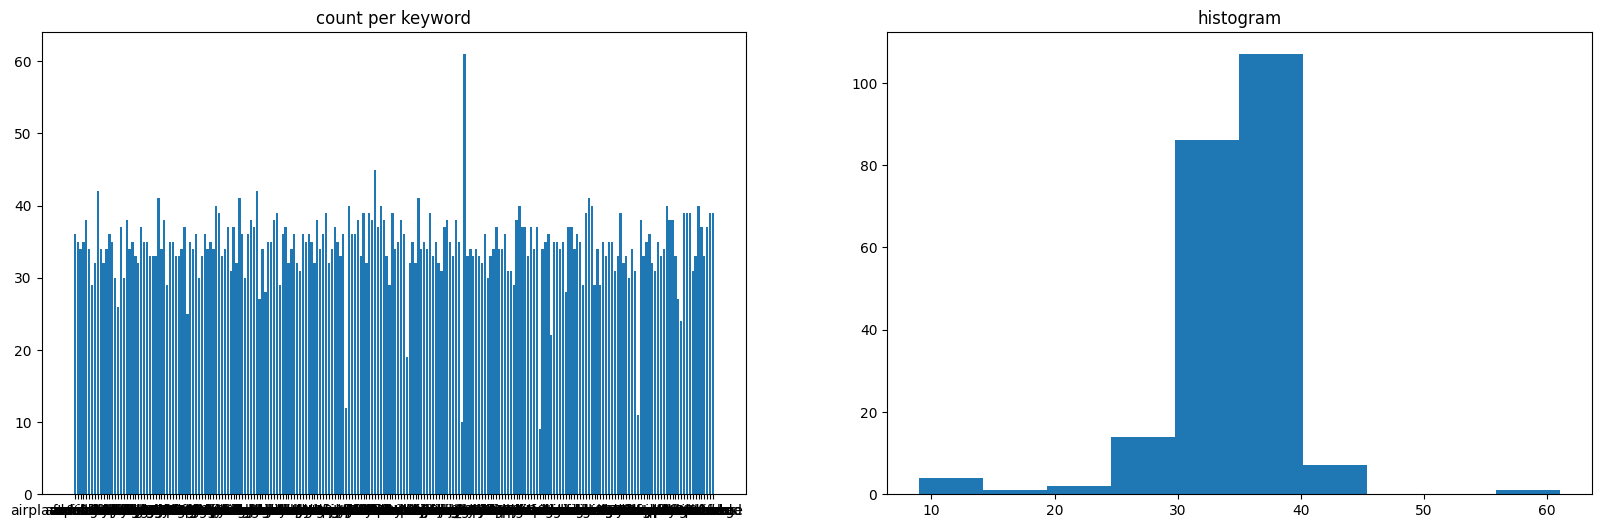

In [10]:
plt.figure(figsize=(20,6))
plt.subplot(121, title="count per keyword")
plt.bar(train_df.groupby("keyword").count().index, train_df.groupby("keyword").count()["id"])
plt.subplot(122, title="histogram")
plt.hist(train_df.groupby("keyword").count()["id"])
plt.show()

### Percentage of the positive value in the target variable
Almost half are related to natual disaster. We can say that the data is not biased.

In [11]:
# percentage of the data with "positive" target variables 
print(train_df.target.sum() / train_df.shape[0] * 100)

42.96597924602653


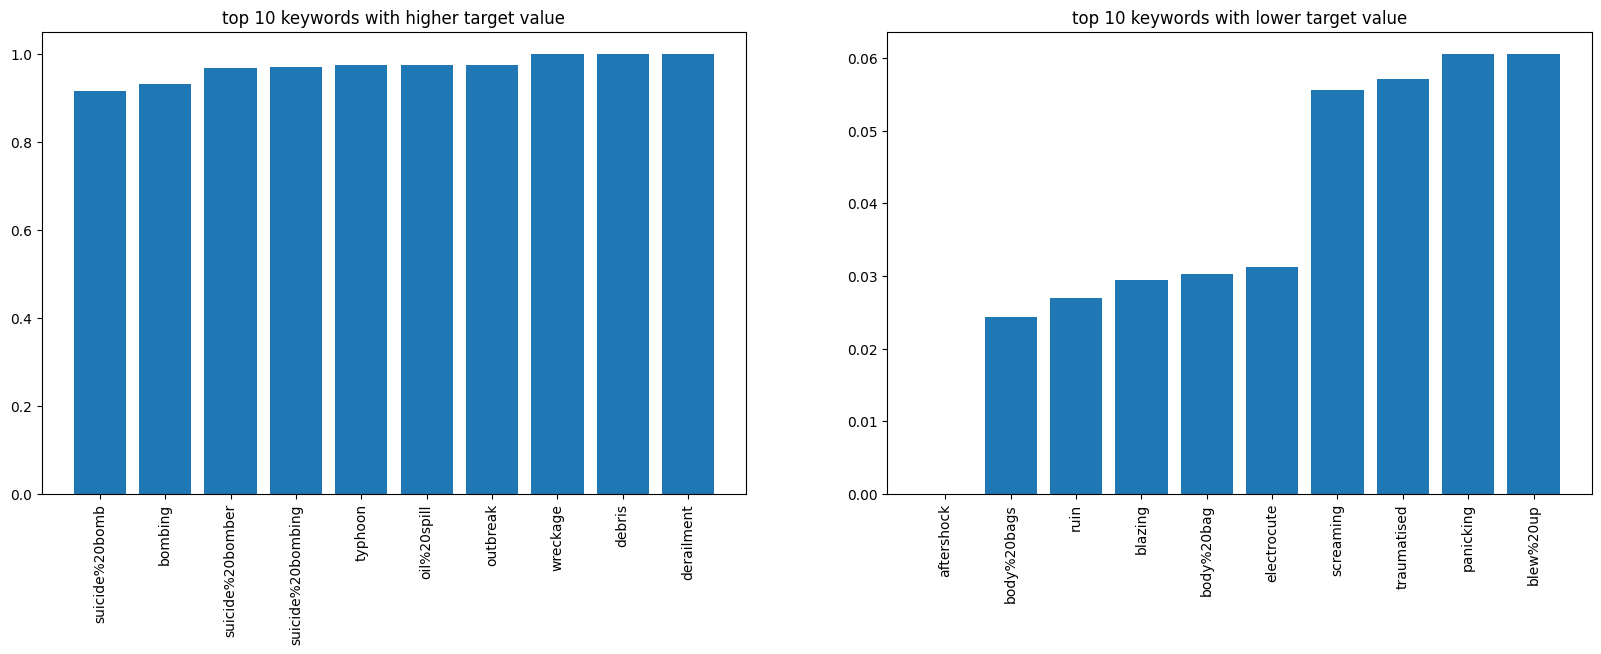

In [12]:
# calc and store mean target per each keyword
tmp = train_df.groupby('keyword')['target'].mean().sort_values()

plt.figure(figsize=(20,6))
plt.subplot(121, title="top 10 keywords with higher target value")
plt.bar(tmp[-10:].index, tmp[-10:].values)
plt.xticks(rotation=90)
plt.subplot(122, title="top 10 keywords with lower target value")
plt.bar(tmp[:10].index, tmp[:10].values)
plt.xticks(rotation=90)
plt.show()

### Add some feature values can be extract from tweets
Tweet data itself will be used as the explanatory variables.  
But we can extract several "characteristic" values for the analysis.

In [13]:
# word count in the tweet
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# number of unique word in the tweet
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# number of stop_word in the tweet
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# number of "http" or "https" in the tweet which usually used as url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# number of # in the tweet which usually used as hashtags
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# number of @ in the tweet mark which usually used as mentions
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

train_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,hashtag_count,mention_count
0,1,invalid_keyword,invalid_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,1,0
1,4,invalid_keyword,invalid_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,0,0
2,5,invalid_keyword,invalid_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,0,0
3,6,invalid_keyword,invalid_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,1,0
4,7,invalid_keyword,invalid_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,2,0


### Visualize those additioal features
It seems that some features can be a clue for differntiation, for example:

* too short (few word count) tweet tend to be not-disaster, and no reference to the URL tends to be not-disaster.

But there are very few apparent differneces can be observed.

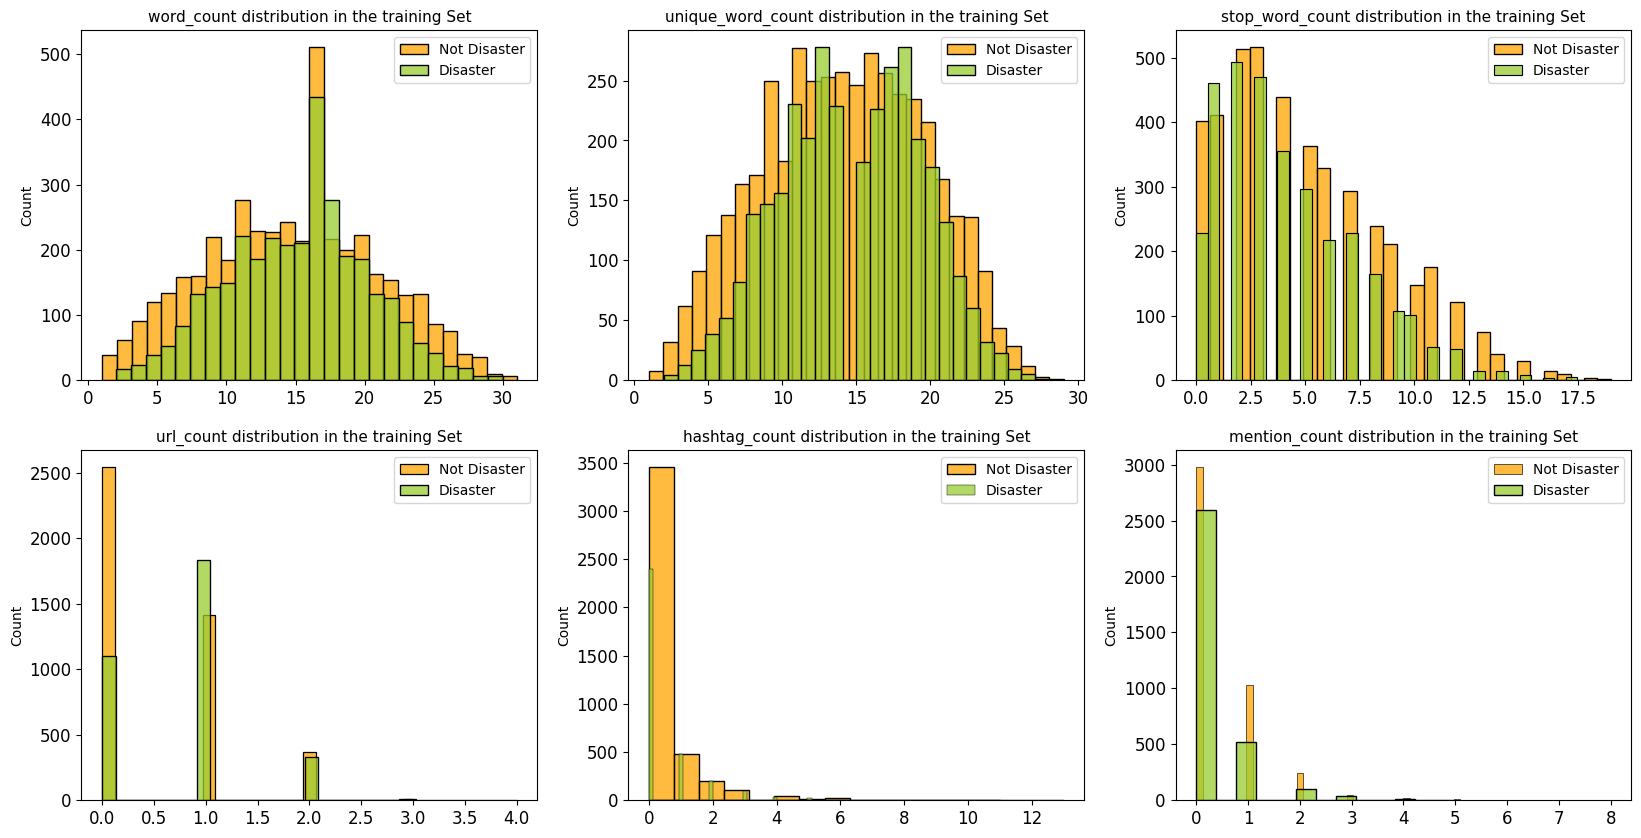

In [14]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
axes = axes.ravel()

for i, feature in enumerate(METAFEATURES):
    sns.histplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', color='orange', ax=axes[i])
    sns.histplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', color='yellowgreen', ax=axes[i])

    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()

    axes[i].set_title(f'{feature} distribution in the training Set', fontsize=11)

plt.show()

### Text preprocessing
in order to minimize unintended variation in the tweet, several preprocessing were applied.

In [15]:
def to_lowercase(tweet):
    """ make tweet lower-case
    """
    loweredcase_tweet = tweet.lower()
    return loweredcase_tweet

def text_cleaning(tweet):
    """ remove tweets and special characters
    """
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "http", tweet) # remove content of the url (http is kept as the number of url can be a clue)
    tweet = re.sub(r"[^a-zA-Z0-9\s]", "", tweet) # remove special char
    return tweet

In [16]:
train_df['lowered_text'] = train_df['text'].apply(lambda t : to_lowercase(t))
test_df['lowered_text'] = test_df['text'].apply(lambda t : to_lowercase(t))

train_df['clean_text'] = train_df['lowered_text'].apply(lambda t : text_cleaning(t))
test_df['clean_text'] = test_df['lowered_text'].apply(lambda t : text_cleaning(t))

In [17]:
train_df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,hashtag_count,mention_count,lowered_text,clean_text
0,1,invalid_keyword,invalid_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,1,0,our deeds are the reason of this #earthquake m...,our deeds are the reason of this earthquake ma...
1,4,invalid_keyword,invalid_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,0,0,forest fire near la ronge sask. canada,forest fire near la ronge sask canada
2,5,invalid_keyword,invalid_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,0,0,all residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,6,invalid_keyword,invalid_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,1,0,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,7,invalid_keyword,invalid_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,2,0,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby alaska as s...


### Define variables to be used for trainig/validation
I'll use only cleaned text as the explanatory variables.

In [18]:
X = train_df['clean_text']
y = train_df['target']
y = np.array(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

***
## Apply Model

### Multinomial Naive Bayes
[Mutinomial NB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) is suitable for classification with dicrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work..

It seems that our model is suffering from a bit of overfitting.  But it seems not bad as it was not easy to guess the target variable from given tweet.

In [19]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

In [20]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
y_train_nb = nb_classifier.predict(X_train_tfidf)
y_pred_nb = nb_classifier.predict(X_valid_tfidf)

In [21]:
print('Naive Bayes Classifier')
print(f'Accuracy: {accuracy_score(y_train, y_train_nb):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_nb):.4f}')
print('Naive Bayes Classifier')
print(f'Accuracy: {accuracy_score(y_valid, y_pred_nb):.4f}')
print(f'F1 score: {f1_score(y_valid, y_pred_nb):.4f}')

Naive Bayes Classifier
Accuracy: 0.8904
F1 score: 0.8604
Naive Bayes Classifier
Accuracy: 0.8069
F1 score: 0.7367


### Bidirectional LSTM
[Bidirectional Layer](https://keras.io/api/layers/recurrent_layers/bidirectional/) is used to train using sentences using both forward direction and backward direction. This task is to predict if the tweet is derived from natural disaster or not. So its reasonable to utilize backward directional information.

#### Preprocessing

In [22]:
VOCAB_SIZE = 15000
SENTENCE_LENGTH = 15
VECTOR_FEAT = 32

onehot_vec_train = [one_hot(words, VOCAB_SIZE) for words in X_train]
onehot_vec_valid = [one_hot(words, VOCAB_SIZE) for words in X_valid]

word_len = []
for i in onehot_vec_train:
    word_len.append(len(i))

print(f'Maximum word length: {max(word_len)}')
print(f'Minimum word length: {min(word_len)}')

embedded_docs_train = pad_sequences(onehot_vec_train, padding='post', maxlen=SENTENCE_LENGTH)
embedded_docs_valid = pad_sequences(onehot_vec_valid, padding='post', maxlen=SENTENCE_LENGTH)

Maximum word length: 31
Minimum word length: 1


#### Model
Input data is embeddeed and then provided to Bidirectional LSTM. And then the output goes through additional Dense layers to get the prediction result.

In [23]:
def model():
    lstm_model = Sequential()
    lstm_model.add(Input(shape=(SENTENCE_LENGTH,)))
    lstm_model.add(Embedding(VOCAB_SIZE, VECTOR_FEAT))
    lstm_model.add(Bidirectional(LSTM(100, return_sequences=True)))
    lstm_model.add(GlobalMaxPooling1D())
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(10, activation='relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(1, activation='sigmoid'))

    return lstm_model

In [24]:
lstm_model = model()
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 32)            480000    
                                                                 
 bidirectional (Bidirectiona  (None, 15, 200)          106400    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                        

In [25]:
history = lstm_model.fit(embedded_docs_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
167/167 [==============================] - 5s 10ms/step - loss: 0.6080 - accuracy: 0.6725
Epoch 2/3
167/167 [==============================] - 2s 10ms/step - loss: 0.4296 - accuracy: 0.8172
Epoch 3/3
167/167 [==============================] - 2s 10ms/step - loss: 0.3089 - accuracy: 0.8872


### See the Score
Unfortunately, the result wasn't so good.  
It seems that the model is easy to overfit, as Naiive Bayes already overfits with the training data, we can imagine deep learning based approach overfits more easily. I guess we need more data, or better understanding of this domain so that we can apply appropriate network architecture for this specific task.

In [26]:
y_train_lstm = (lstm_model.predict(embedded_docs_train) > 0.5).astype("int32")
y_pred_lstm = (lstm_model.predict(embedded_docs_valid) > 0.5).astype("int32")

72/72 [==============================] - 0s 3ms/step


In [27]:
print('LSTM train')
print(f'Accuracy: {accuracy_score(y_train, y_train_lstm):.4f}')
print(f'F1 score: {f1_score(y_train, y_train_lstm):.4f}')
print('LSTM valid')
print(f'Accuracy: {accuracy_score(y_valid, y_pred_lstm):.4f}')
print(f'F1 score: {f1_score(y_valid, y_pred_lstm):.4f}')

LSTM train
Accuracy: 0.9204
F1 score: 0.8994
LSTM valid
Accuracy: 0.7583
F1 score: 0.6511


***
## Conclusion
It seems that the DNN based approach applied here overfits to the trainig data and couldn't provide good result compared with simpler approach.  
Maybe further study required to fully understand what kind of architecture fits with this kind of task.

### Let's use Naive Bayes Classifier and make output
As the result seems better with Naive Bayes Classifier. I'll use this as the output for my assignment.

In [28]:
test_df.head()

,id,keyword,location,text,word_count,unique_word_count,stop_word_count,url_count,hashtag_count,mention_count,lowered_text,clean_text
0,0,invalid_keyword,invalid_location,Just happened a terrible car crash,6,6,2,0,0,0,just happened a terrible car crash,just happened a terrible car crash
1,2,invalid_keyword,invalid_location,"Heard about #earthquake is different cities, s...",9,9,2,0,1,0,"heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,invalid_keyword,invalid_location,"there is a forest fire at spot pond, geese are...",19,19,10,0,0,0,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,invalid_keyword,invalid_location,Apocalypse lighting. #Spokane #wildfires,4,4,0,0,2,0,apocalypse lighting. #spokane #wildfires,apocalypse lighting spokane wildfires
4,11,invalid_keyword,invalid_location,Typhoon Soudelor kills 28 in China and Taiwan,8,8,2,0,0,0,typhoon soudelor kills 28 in china and taiwan,typhoon soudelor kills 28 in china and taiwan


In [29]:
X_test_df = test_df['clean_text']
X_test_df = tfidf_vectorizer.transform(X_test_df)
predictions = nb_classifier.predict(X_test_df)

ids = test_df['id']
prediction_df = pd.DataFrame({'id':ids, 'target':predictions})
prediction_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


In [30]:
prediction_df.to_csv('submission.csv', index=False)